##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tuning with FunctionGemma

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemma/docs/functiongemma/finetuning-with-functiongemma"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/functiongemma/finetuning-with-functiongemma.ipynb""><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/functiongemma/finetuning-with-functiongemma.ipynb"><img src="https://www.kaggle.com/static/images/logos/kaggle-logo-transparent-300.png" height="32" width="70"/>Run in Kaggle</a>
  </td>
  <td>
    <a target="_blank" href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fgoogle%2Fgenerative-ai-docs%2Fmain%2Fsite%2Fen%2Fgemma%2Fdocs%2Ffunctiongemma%2Ffinetuning-with-functiongemma.ipynb"><img src="https://ai.google.dev/images/cloud-icon.svg" width="40" />Open in Vertex AI</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/functiongemma/finetuning-with-functiongemma.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This guide demonstrates how to fine-tune FunctionGemma for tool calling.

While FunctionGemma is natively capable of calling tools. But true capability comes from two distinct skills: the mechanical knowledge of how to use a tool (syntax) and the cognitive ability to interpret *why* and *when* to use it (intent).

Models, especially smaller ones, have fewer parameters available to retain complex intent understanding. This is why we need to fine-tune them

Common use cases for fine-tuning tool calling include:

- **Model Distillation**: Generating synthetic training data with a larger model and fine-tuning a smaller model to replicate the specific workflow efficiently.
- **Handling Non-Standard Schemas**: Overcoming base model struggles with legacy, highly complex data structures or proprietary format not found in public data, such as handling [domain-specific mobile actions](https://ai.google.dev/gemma/docs/mobile-actions).
- **Optimizing Context Usage**: "Baking" tool definitions into the model's weights. This allows you to use shorthand descriptions in your prompts, freeing up the context window for the actual conversation.
- **Resolving Selection Ambiguity**: Biasing the model toward specific enterprise policies, such as prioritizing an internal knowledge base over an external search engine.

In this example, we will focus specifically on managing tool selection ambiguity.

## Setup development environment

The first step is to install Hugging Face Libraries, including TRL, and datasets to fine-tune open model, including different RLHF and alignment techniques.

In [ ]:
# Install Pytorch & other libraries
%pip install torch tensorboard

# Install Hugging Face libraries
%pip install transformers datasets accelerate evaluate trl protobuf sentencepiece

# COMMENT IN: if you are running on a GPU that supports BF16 data type and flash attn, such as NVIDIA L4 or NVIDIA A100
#% pip install flash-attn

> _Note: If you are using a GPU with Ampere architecture (such as NVIDIA L4) or newer, you can use Flash attention. Flash Attention is a method that significantly speeds computations up and reduces memory usage from quadratic to linear in sequence length, leading to acelerating training up to 3x. Learn more at [FlashAttention](https://github.com/Dao-AILab/flash-attention/tree/main)._

Before you can start training, you have to make sure that you accepted the terms of use for Gemma. You can accept the license on [Hugging Face](http://huggingface.co/google/functiongemma-270m-it) by clicking on the **Agree** and access repository button on the model page at: http://huggingface.co/google/functiongemma-270m-it

After you have accepted the license, you need a valid Hugging Face Token to access the model. If you are running inside a Google Colab, you can securely use your Hugging Face Token using the Colab secrets otherwise you can set the token as directly in the `login` method. Make sure your token has write access too, as you push your model to Hugging Face Hub after fine-tuning.

In [ ]:
# Login into Hugging Face Hub
from huggingface_hub import login
login()

You can keep the results on Colab's local virtual machine. However, we highly recommend saving your intermediate results to your Google Drive. This ensures your training results are safe and allows you to easily compare and select the best model.

Also, adjust the checkpoint directory and the learning rate.

In [ ]:
from google.colab import drive

mount_google_drive = False #@param {type:"boolean"}
checkpoint_dir = "functiongemma-270m-it-simple-tool-calling" #@param {type:"string"}

if mount_google_drive:
    drive.mount('/content/drive')
    checkpoint_dir = f"/content/drive/MyDrive/{checkpoint_dir}"

print(f"Checkpoints will be saved to {checkpoint_dir}")

base_model = "google/functiongemma-270m-it"
learning_rate = 5e-5 #@param {type:"number"}

Checkpoints will be saved to functiongemma-270m-it-simple-tool-calling


## Prepare the fine-tuning dataset

You will use the following example dataset, which contains sample conversations requiring a choice between two tools: `search_knowledge_base` and `search_google`.


In [ ]:
#@title Simple tool calling dataset
simple_tool_calling = [
  {"user_content":"What is the reimbursement limit for travel meals?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"travel meal reimbursement limit policy\"}"},
  {"user_content":"What is the current stock price of Google?","tool_name":"search_google","tool_arguments":"{\"query\": \"current Google stock price\"}"},
  {"user_content":"How do I configure the VPN for the New York office?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"VPN configuration guide New York office\"}"},
  {"user_content":"Explain the difference between REST and GraphQL.","tool_name":"search_google","tool_arguments":"{\"query\": \"difference between REST and GraphQL\"}"},
  {"user_content":"Who is the product owner for Project Chimera?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"Project Chimera product owner\"}"},
  {"user_content":"Find the documentation for the 'requests' library in Python.","tool_name":"search_google","tool_arguments":"{\"query\": \"Python requests library documentation\"}"},
  {"user_content":"What are the core values listed in our employee handbook?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"employee handbook core values\"}"},
  {"user_content":"What is the weather forecast for the company retreat in Bali?","tool_name":"search_google","tool_arguments":"{\"query\": \"weather forecast Bali\"}"},
  {"user_content":"I need to reset my Okta password. How do I do that?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"Okta password reset procedure\"}"},
  {"user_content":"Who won the World Series last year?","tool_name":"search_google","tool_arguments":"{\"query\": \"MLB World Series winner last year\"}"},
  {"user_content":"What is the guest Wi-Fi password for the 4th floor?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"guest wifi password 4th floor\"}"},
  {"user_content":"Comparison of AWS vs GCP pricing.","tool_name":"search_google","tool_arguments":"{\"query\": \"AWS vs GCP pricing comparison\"}"},
  {"user_content":"How do I install our internal 'utils-core' package?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"install utils-core package internal registry\"}"},
  {"user_content":"What are the dates for the upcoming federal holidays?","tool_name":"search_google","tool_arguments":"{\"query\": \"upcoming federal holidays dates\"}"},
  {"user_content":"Does the office insurance cover dental implants?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"dental insurance coverage implants\"}"},
  {"user_content":"What is the latest version of Node.js?","tool_name":"search_google","tool_arguments":"{\"query\": \"latest Node.js version\"}"},
  {"user_content":"Find the meeting minutes from last week's All-Hands.","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"All-Hands meeting minutes last week\"}"},
  {"user_content":"What did our competitor, ABC Corp, announce at CES today?","tool_name":"search_google","tool_arguments":"{\"query\": \"ABC Corp announcements CES today\"}"},
  {"user_content":"Who is the emergency contact for the London data center?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"emergency contact London data center\"}"},
  {"user_content":"Convert 100 USD to JPY.","tool_name":"search_google","tool_arguments":"{\"query\": \"100 USD to JPY exchange rate\"}"},
  {"user_content":"How do I access my paystubs on the ADP portal?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"access paystubs ADP portal guide\"}"},
  {"user_content":"What is the syntax for Python list comprehensions?","tool_name":"search_google","tool_arguments":"{\"query\": \"python list comprehension syntax examples\"}"},
  {"user_content":"Where can I find the floor plan for Building B?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"floor plan Building B conference rooms\"}"},
  {"user_content":"Check the latest stock price for Apple.","tool_name":"search_google","tool_arguments":"{\"query\": \"Apple stock price today\"}"},
  {"user_content":"What is the procedure for reporting a phishing email?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"report phishing email security procedure\"}"},
  {"user_content":"Show me examples of using the useEffect hook in React.","tool_name":"search_google","tool_arguments":"{\"query\": \"React useEffect hook code examples\"}"},
  {"user_content":"Who are the direct reports for the VP of Engineering?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"VP of Engineering org chart direct reports\"}"},
  {"user_content":"How do I list open ports on a Linux server?","tool_name":"search_google","tool_arguments":"{\"query\": \"linux command check open ports\"}"},
  {"user_content":"What is our Slack message retention policy?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"Slack public channel data retention policy\"}"},
  {"user_content":"Compare the features of iPhone 15 vs Samsung S24.","tool_name":"search_google","tool_arguments":"{\"query\": \"iPhone 15 vs Samsung S24 feature comparison\"}"},
  {"user_content":"I need the expense code for team building events.","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"finance expense code team building\"}"},
  {"user_content":"Best practices for writing a Dockerfile for Node.js.","tool_name":"search_google","tool_arguments":"{\"query\": \"Dockerfile best practices Node.js application\"}"},
  {"user_content":"How do I request a new monitor setup?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"IT hardware request monitor setup\"}"},
  {"user_content":"What is the difference between VLOOKUP and XLOOKUP in Google Sheets?","tool_name":"search_google","tool_arguments":"{\"query\": \"Google Sheets VLOOKUP vs XLOOKUP difference\"}"},
  {"user_content":"Find the onboarding checklist for new engineering hires.","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"new hire onboarding checklist engineering\"}"},
  {"user_content":"What are the latest release notes for the OpenAI API?","tool_name":"search_google","tool_arguments":"{\"query\": \"OpenAI API latest release notes\"}"},
  {"user_content":"Do we have preferred hotel partners in Paris?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"corporate travel preferred hotels Paris\"}"},
  {"user_content":"How to undo the last git commit but keep the changes?","tool_name":"search_google","tool_arguments":"{\"query\": \"git reset soft undo last commit\"}"},
  {"user_content":"What is the process for creating a new Jira project?","tool_name":"search_knowledge_base","tool_arguments":"{\"query\": \"create new Jira project process\"}"},
  {"user_content":"Tutorial on SQL window functions.","tool_name":"search_google","tool_arguments":"{\"query\": \"SQL window functions tutorial\"}"},
]

Consider the query: "What are the best practices for writing a simple recursive function in Python?"

The appropriate tool depends entirely on your specific policy. While a generic model naturally defaults to `search_google`, an enterprise application usually needs to check `search_knowledge_base` first.

**Note on Data Splitting**: For this demonstration, we will implement a 50/50 train-test split. While an 80/20 split is standard for production workflows, this equal division is chosen specifically to highlight the model's performance improvement on unseen data.

In [ ]:
import json
from datasets import Dataset
from transformers.utils import get_json_schema

# --- Tool Definitions ---
def search_knowledge_base(query: str) -> str:
    """
    Search internal company documents, policies and project data.

    Args:
        query: query string
    """
    return "Internal Result"

def search_google(query: str) -> str:
    """
    Search public information.

    Args:
        query: query string
    """
    return "Public Result"


TOOLS = [get_json_schema(search_knowledge_base), get_json_schema(search_google)]

DEFAULT_SYSTEM_MSG = "You are a model that can do function calling with the following functions"

def create_conversation(sample):
  return {
      "messages": [
          {"role": "developer", "content": DEFAULT_SYSTEM_MSG},
          {"role": "user", "content": sample["user_content"]},
          {"role": "assistant", "tool_calls": [{"type": "function", "function": {"name": sample["tool_name"], "arguments": json.loads(sample["tool_arguments"])}}]},
      ],
      "tools": TOOLS
  }

dataset = Dataset.from_list(simple_tool_calling)
# You can also load the dataset from Hugging Face Hub
# dataset = load_dataset("bebechien/SimpleToolCalling", split="train")

# Convert dataset to conversational format
dataset = dataset.map(create_conversation, remove_columns=dataset.features, batched=False)

# Split dataset into 50% training samples and 50% test samples
dataset = dataset.train_test_split(test_size=0.5, shuffle=True)

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

**Important Note on Dataset Distribution**

When using `shuffle=False` to your own custom datasets, ensure your source data is pre-mixed. If the distribution is unknown or sorted, you should use `shuffle=True` to ensure the model learns a balanced representation of all tools during training.


## Fine-tune FunctionGemma using TRL and the SFTTrainer

You are now ready to fine-tune your model. Hugging Face TRL [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer) makes it straightforward to supervise fine-tune open LLMs. The `SFTTrainer` is a subclass of the `Trainer` from the `transformers` library and supports all the same features,

The following code loads the FunctionGemma model and tokenizer from Hugging Face.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(base_model)

print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

# Print formatted user prompt
print("--- dataset input ---")
print(json.dumps(dataset["train"][0], indent=2))
debug_msg = tokenizer.apply_chat_template(dataset["train"][0]["messages"], tools=dataset["train"][0]["tools"], add_generation_prompt=False, tokenize=False)
print("--- Formatted prompt ---")
print(debug_msg)

Device: cuda:0
DType: torch.bfloat16
--- dataset input ---
{
  "messages": [
    {
      "content": "You are a model that can do function calling with the following functions",
      "role": "developer",
      "tool_calls": null
    },
    {
      "content": "What is the reimbursement limit for travel meals?",
      "role": "user",
      "tool_calls": null
    },
    {
      "content": null,
      "role": "assistant",
      "tool_calls": [
        {
          "function": {
            "arguments": {
              "query": "travel meal reimbursement limit policy"
            },
            "name": "search_knowledge_base"
          },
          "type": "function"
        }
      ]
    }
  ],
  "tools": [
    {
      "function": {
        "description": "Search internal company documents, policies and project data.",
        "name": "search_knowledge_base",
        "parameters": {
          "properties": {
            "query": {
              "description": "query string",
              "

## Before fine-tune

The output below shows that the out-of-the-box capabilities may not be good enough for this use case.

In [ ]:
def check_success_rate():
  success_count = 0
  for idx, item in enumerate(dataset['test']):
    messages = [
        item["messages"][0],
        item["messages"][1],
    ]

    inputs = tokenizer.apply_chat_template(messages, tools=TOOLS, add_generation_prompt=True, return_dict=True, return_tensors="pt")

    out = model.generate(**inputs.to(model.device), pad_token_id=tokenizer.eos_token_id, max_new_tokens=128)
    output = tokenizer.decode(out[0][len(inputs["input_ids"][0]) :], skip_special_tokens=False)

    print(f"{idx+1} Prompt: {item['messages'][1]['content']}")
    print(f"  Output: {output}")

    expected_tool = item['messages'][2]['tool_calls'][0]['function']['name']
    other_tool = "search_knowledge_base" if expected_tool == "search_google" else "search_google"

    if expected_tool in output and other_tool not in output:
      print("  `-> ✅ correct!")
      success_count += 1
    elif expected_tool not in output:
      print(f"  -> ❌ wrong (expected '{expected_tool}' missing)")
    else:
      if output.startswith(f"<start_function_call>call:{expected_tool}"):
        print(f"  -> ⚠️ tool is correct {expected_tool}, but other_tool exists in output")
      else:
        print(f"  -> ❌ wrong (hallucinated '{other_tool}')")

  print(f"Success : {success_count} / {len(dataset['test'])}")

check_success_rate()

1 Prompt: How do I access my paystubs on the ADP portal?
  Output: I cannot assist with accessing or retrieving paystubs or other company documents on the ADP portal. My current capabilities are limited to assisting with searching internal company documents and knowledge base queries.<end_of_turn>
  -> ❌ wrong (expected 'search_knowledge_base' missing)
2 Prompt: What is the syntax for Python list comprehensions?
  Output: I cannot assist with programming or providing programming syntax information. My current capabilities are focused on searching internal company documents and project data.<end_of_turn>
  -> ❌ wrong (expected 'search_google' missing)
3 Prompt: Where can I find the floor plan for Building B?
  Output: <start_function_call>call:search_knowledge_base{query:<escape>Floor plan for Building B<escape>}<end_function_call><start_function_call>call:search_google{query:<escape>Floor plan for Building B<escape>}<end_function_call><start_function_response>
  -> ⚠️ tool is correct s

## Training

Before you can start your training, you need to define the hyperparameters you want to use in a `SFTConfig` instance.

In [ ]:
from trl import SFTConfig

torch_dtype = model.dtype

args = SFTConfig(
    output_dir=checkpoint_dir,              # directory to save and repository id
    max_length=512,                         # max sequence length for model and packing of the dataset
    packing=False,                          # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=8,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_checkpointing=False,           # Caching is incompatible with gradient checkpointing
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=1,                        # log every step
    #save_strategy="epoch",                  # save checkpoint every epoch
    eval_strategy="epoch",                  # evaluate checkpoint every epoch
    learning_rate=learning_rate,            # learning rate
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,  # use bfloat16 precision
    lr_scheduler_type="constant",            # use constant learning rate scheduler
    push_to_hub=True,                        # push model to hub
    report_to="tensorboard",                 # report metrics to tensorboard
)

You now have every building block you need to create your `SFTTrainer` to start the training of your model.

In [ ]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    processing_class=tokenizer,
)

Tokenizing train dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Start training by calling the `train()` method.

In [ ]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.800300,0.648739,0.590625,3241.000000,0.888866
2,0.269600,0.430649,0.310939,6482.000000,0.937447
3,0.179600,0.442410,0.217868,9723.000000,0.933030
4,0.104800,0.469016,0.196222,12964.000000,0.933815
5,0.064500,0.436476,0.183889,16205.000000,0.937461
6,0.054400,0.489788,0.119700,19446.000000,0.940793
7,0.035100,0.498824,0.083078,22687.000000,0.944682
8,0.036200,0.502200,0.093177,25928.000000,0.944957


To plot the training and validation losses, you would typically extract these values from the `TrainerState` object or the logs generated during training.

Libraries like Matplotlib can then be used to visualize these values over training steps or epochs. The x-asis would represent the training steps or epochs, and the y-axis would represent the corresponding loss values.

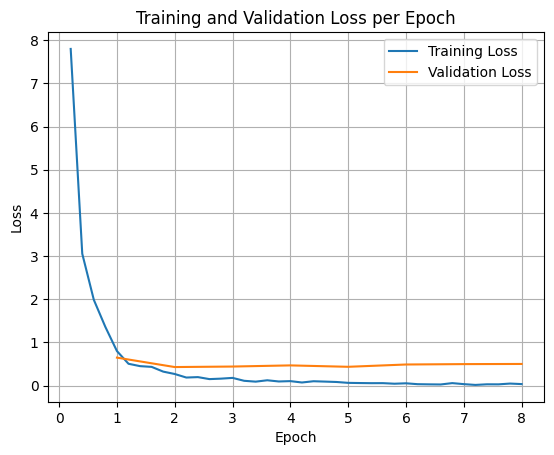

In [ ]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Test Model Inference

After the training is done, you'll want to evaluate and test your model. You can load different samples from the test dataset and evaluate the model on those samples.


In [ ]:
check_success_rate()


1 Prompt: How do I access my paystubs on the ADP portal?
  Output: <start_function_call>call:search_knowledge_base{query:<escape>paystubs API portal access codes<escape>}<end_function_call><start_function_response>
  `-> ✅ correct!
2 Prompt: What is the syntax for Python list comprehensions?
  Output: <start_function_call>call:search_google{query:<escape>Python list comprehensions syntax<escape>}<end_function_call><start_function_response>
  `-> ✅ correct!
3 Prompt: Where can I find the floor plan for Building B?
  Output: <start_function_call>call:search_knowledge_base{query:<escape>floor plan Building B floor plan<escape>}<end_function_call><start_function_response>
  `-> ✅ correct!
4 Prompt: Check the latest stock price for Apple.
  Output: <start_function_call>call:search_google{query:<escape>latest stock price Apple<escape>}<end_function_call><start_function_response>
  `-> ✅ correct!
5 Prompt: What is the procedure for reporting a phishing email?
  Output: <start_function_call>ca

## Summary and next steps

You learned how to fine-tune FunctionGemma to resolve **tool selection ambiguity**, a scenario where a model must choose between overlapping tools (e.g., internal vs. external search) based on specific enterprise policies. By utilizing the **Hugging Face TRL library** and `SFTTrainer`, the tutorial walked through the process of preparing a dataset, configuring hyperparameters, and executing a supervised fine-tuning loop.

The results illustrate the critical difference between a "capable" base model and a "production-ready" fine-tuned model:

- **Before Fine-tuning**: The base model struggled to adhere to the specific policy, often failing to call tools or choosing the wrong one, resulting in a low success rate (e.g., 2/20).
- **After Fine-tuning**: After training for 8 epochs, the model learned to correctly distinguish between queries requiring search_knowledge_base versus search_google, improving the success rate (e.g., 16/20).

Now that you have a fine-tuned model, consider the following steps to move toward production:

- **Expand the Dataset**: The current dataset was a small, synthetic split (50/50) used for demonstration. For a robust enterprise application, curate a larger, more diverse dataset that covers edge cases and rare policy exceptions.
- **Evaluation with RAG**: Integrate the fine-tuned model into a Retrieval Augmented Generation (RAG) pipeline to verify that the `search_knowledge_base` tool calls actually retrieve relevant documents and result in accurate final answers.

Check out the following docs next:

- [Full function calling sequence with FunctionGemma](https://ai.google.dev/gemma/docs/functiongemma/full-function-calling-sequence-with-functiongemma)
- [Finetune FunctionGemma for Mobile Actions](https://github.com/google-gemini/gemma-cookbook/blob/main/FunctionGemma/%5BFunctionGemma%5DFinetune_FunctionGemma_270M_for_Mobile_Actions_with_Hugging_Face.ipynb) in the Gemma Cookbook
